In [1]:
%set_env TF_FORCE_GPU_ALLOW_GROWTH=true
import pandas as pd
import numpy as np
import os
import re
from PIL import Image
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline

env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [2]:
def preprocess_dataframe(df):
    
    '''
        Reads & preprocess dataframe w/ 3 labels: time, signal, label
    '''
    
    #df = df.iloc[:, 1:] # use system time - keep for DenoisedNormalizedData set
    df.columns = ['time','signal_val','label'] # set labels
    df = df.loc[df.time.notnull()].copy() # getting only not null values
    #df.time = (df.time * 1000).astype('int') #- keep for DenoisedNormalizedData set
    
    df = df.iloc[1:,:] # removes first row of labels
    
    df["label"] = df["label"].astype('str').astype('int')
    df["time"] = df["time"].astype('str').astype('int')
    df["signal_val"] = df["signal_val"].astype('str').astype('double')
    #df.label = df.label.astype('int') # labels as int - keep for DenoisedNormalizedData set
    
    return df

In [3]:
def import_train_test_data(data_dir, test_user=None):
    
    '''
        See here for more info:
        https://github.com/atabas/Heartbeat-Classification/blob/master/ImageConversion.ipynb
    '''
    
    train = pd.DataFrame([], columns=['time', 'signal_val', 'label'])    # train dataset
    test = pd.DataFrame([], columns=['time', 'signal_val', 'label'])     # test dataset
    #sumat = 0
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            
            df = pd.read_csv(data_dir + '/' + filename, header=None)
            df = preprocess_dataframe(df)
            #print(df.shape)
            #sumat = sumat + df.shape[0]
            
            user_num = int(re.findall(r'\d+',filename.split('_')[0])[0]) #get user number
            
            # Check if ignore_user
            if (user_num != test_user):
                train = train.append(df)
            else:
                test = test.append(df)
                '''
                window_intervals = [0.25, 0.5, 1, 2, 3, 5, 10, 15, 20, 25, 30]
                min_ts_lens = {
                    0.25 : 50,
                    0.5 : 100,
                    1 : 224,
                    2 : 224,
                    3 : 224,
                    5 : 224,
                    10 : 224,
                    15 : 224,
                    20 : 224,
                    25 : 224,
                    30 : 224
                }
                '''  
    #print(sumat)
    return train, test

In [4]:
def map_to_image(train, test):
    '''
        Converts signal_vals to [0,255] range
    '''
    # Get smallest signal_val
    if (train['signal_val'].min() < test['signal_val'].min()):
        min_val = train['signal_val'].min()
    else:
        min_val = test['signal_val'].min() 
    
    # Normalize signal-val values to be positive only
    train['signal_val'] += abs(min_val)
    test['signal_val'] += abs(min_val)
    
    # Get max signal_val
    if (train['signal_val'].max() > test['signal_val'].max()):
        max_val = train['signal_val'].max()
    else:
        max_val = test['signal_val'].max() 
    
    # Expand distribution to cover [0,255] range - 8bit image
    train['signal_val'] *= 255 / max_val
    test['signal_val'] *= 255 / max_val
    
    return train, test

In [4]:
train_set, test_set = import_train_test_data('IRRlabeldata_3c',test_user=2)
#train_set, test_set = map_to_image(train, test)
train_set.shape

# removing first 2 rows since garbage data
test_set = test_set.iloc[2:,:]
train_set = train_set.iloc[2:,:]
test_set.head()

,time,signal_val,label
3,1642867,0.625378,0
4,1642871,0.386409,0
5,1642875,-0.033411,0
6,1642878,-0.313276,0
7,1642882,-0.128880,0


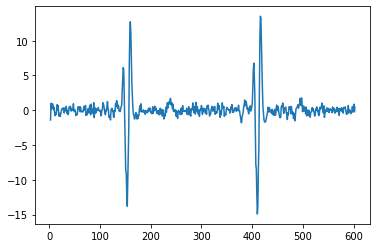

In [5]:
# Plotting
plt.plot(train_set['signal_val'].iloc[0:600])

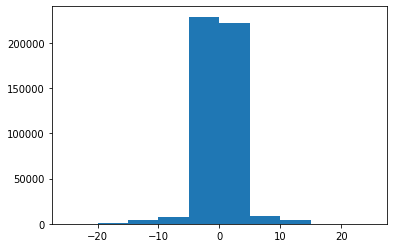

In [6]:
# distribution of signal vals
hist_train = plt.hist(train_set['signal_val'])

In [7]:
test_set.shape

(46389, 3)

In [8]:
train_set.value_counts()

time      signal_val  label
 1000      2.000000   2        10
-11206     25.000000  1         2
 0         25.000000  1         2
 5126890   2.791314   2         1
 1421386  -0.618326   0         1
                               ..
 3111945   11.808141  2         1
 3111949   0.799336   1         1
           11.971828  2         1
 3111953   1.487934   1         1
-66139    -6.392277   1         1
Length: 476377, dtype: int64

In [9]:
# Entries per label
test_set.groupby('label').size()

label
0     7678
1    10240
2    28471
dtype: int64

In [11]:
train_set.groupby('label').size()

label
0     84460
1    102400
2    289528
dtype: int64

In [13]:
train_set['signal_val'].max()

25.0

In [14]:
test_set['signal_val'].max()

10.243976366554334

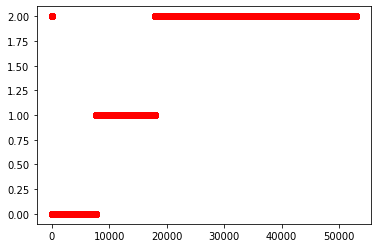

In [15]:
plt.plot(train_set['label'], 'ro')

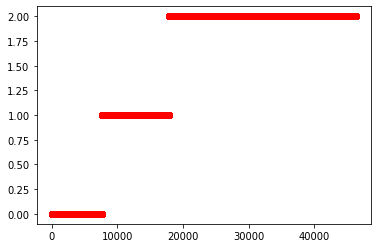

In [16]:
plt.plot(test_set['label'], 'ro')

In [5]:
from math import floor

def time_series_splicing(data, window_size=224):
    
    '''
       Create dataset from time-snippets of window_size length 
    '''
    
    # Dropping time column as not needed
    data = data.drop(columns=['time'])
    num_samples = floor(data.shape[0] / window_size)
    
    print('Total # of samples of window_size = {}: {}'. format(window_size, num_samples))
    
    result = np.empty(shape=(num_samples, 224, 2))
    
    start = 0;
    
    for i in range(num_samples):
        # splice original dataframe into window_size chunks
        result[i,:,:] = data.iloc[start : start + window_size, :]
        #print("spliced from {} to {}".format(start, start+window_size))
        start = start + window_size
    
    print('Splicing done; {} original entries discarded'.format(data.shape[0] - start))
    
    return result

In [6]:
ts_window_size = 224 #224 samples per 1 sample

train_set = time_series_splicing(train_set, ts_window_size)
test_set = time_series_splicing(test_set, ts_window_size)

Total # of samples of window_size = 224: 2126
Splicing done; 164 original entries discarded
Total # of samples of window_size = 224: 207
Splicing done; 21 original entries discarded


In [19]:
train_set.shape

(2126, 224, 2)

In [20]:
test_set.shape

(207, 224, 2)

In [7]:
from sklearn.model_selection import train_test_split

# Splitting into training and validation sets
val_size = 0.2 # 20%
train, val = train_test_split(train_set, test_size = 0.2)

test = test_set

In [22]:
train.shape

(1700, 224, 2)

In [23]:
val.shape

(426, 224, 2)

## InceptionTime Model

### Defining InceptionTime architecture

### 1. InceptionTime module
General architecture for the module seen below:
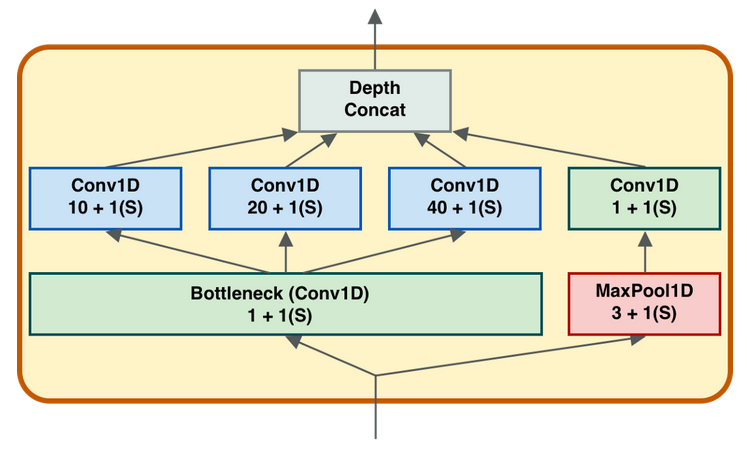

#### 2. Inception Network

Architecture diagram below:

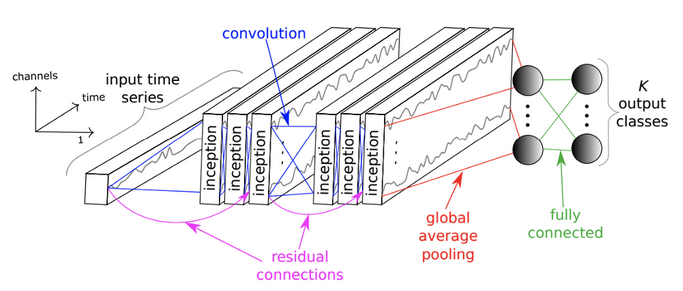

There is an additional residual connection at every third inception module

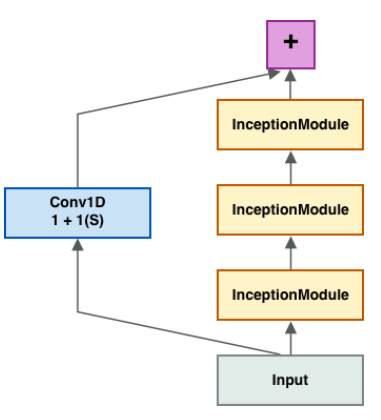

In [42]:
import tensorflow as tf
from tensorflow import keras

class InceptionModule(keras.layers.Layer):
    def __init__(self, num_filters=32, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters
        self.activation = keras.activations.get(activation)
        
    def _default_Conv1D(self, filters, kernel_size):
        return keras.layers.Conv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  strides=1,
                                  activation='relu',
                                  use_bias=False)
    
    def call(self, inputs):
        # Step 1 - Bottleneck (conv1d) and MaxPooling

        conv1D_1 = self._default_Conv1D(filters=self.num_filters, kernel_size=1)(inputs)
        maxpool_1 = keras.layers.MaxPool1D(pool_size=3, strides=1, padding='same')(inputs)
        
        # Step 2 - 1D convolution
        conv1D_2_k10 = self._default_Conv1D(filters=self.num_filters, kernel_size=10)(conv1D_1)
        conv1D_2_k20 = self._default_Conv1D(filters=self.num_filters, kernel_size=20)(conv1D_1)
        conv1D_2_k40 = self._default_Conv1D(filters=self.num_filters, kernel_size=40)(conv1D_1)
        
        conv1D_2_k1 = self._default_Conv1D(filters=self.num_filters, kernel_size=1)(maxpool_1)
        
        # Step 3 - Depth Concatenation and BN
        # EDIT - original is axis=2, im using axis=1
        d_concat = keras.layers.Concatenate(axis=1)([conv1D_2_k10, conv1D_2_k20, conv1D_2_k40, conv1D_2_k1])
        bn = keras.layers.BatchNormalization()(d_concat)
        
        return self.activation(bn)

In [54]:
def shortcut_layer(input_layer, output_layer):
    
    # Create shortcut connection (conv1D + BN) 
    # EDIT: original -> filters=int(out_tensor.shape[-1])
    print(output_layer.shape)
    shortcut = keras.layers.Conv1D(filters=int(output_layer.shape[-1]),
                                  kernel_size=1,
                                  padding='same',
                                  use_bias=False)(input_layer)
    shortcut = keras.layers.BatchNormalization()(shortcut)
    
    # add shortcut to layers
    res_con = keras.layers.Add()([shortcut, output_layer])
    
    return keras.layers.Activation('relu')(res_con)

In [44]:
def inception_time(input_shape, num_classes, loss, batch_size=None, num_modules=6):
    
    # creating a number of inception modules
    input_layer = keras.layers.Input(shape=input_shape, batch_size=batch_size)
    x = input_layer
    x_residual = input_layer
    
    for i in range(num_modules):
        
        x = InceptionModule()(x)
        
        # add residual connection
        if i % 3 == 2:
            x = shortcut_layer(x_residual, x)
            x_residual = x
            
    gap_layer = keras.layers.GlobalAveragePooling1D()(x)
    
    # use for label class classification (original paper)
    #output_layer = keras.layers.Dense(num_classes, activation='softmax')(gap_layers)
    
    output_layer = keras.layers.Dense(num_classes, activation='relu')(gap_layer)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    # use loss='categorical_crossentropy' for classification (original paper)
    
    model.compile(loss=loss, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    return model

In [25]:
train_set.shape[1:]

(224, 2)

In [8]:
# Split samples and labels
x_train = train[:,:,0]
y_train = train[:,:,1]

x_test = test[:,:,0]
y_test = test[:,:,1]

x_val = val[:,:,0]
y_val = val[:,:,1]

# Transform to tf.data.Dataset for easy pipeline
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Create batches
BATCH_SIZE = 12

train_batch = train_data.batch(BATCH_SIZE)
test_batch = test_data.batch(BATCH_SIZE)
val_batch = val_data.batch(BATCH_SIZE)

In [9]:
# Load model
from inceptionTime import inceptionTime
import os
model = inceptionTime(os.getcwd(), (224,1), 224, True, True)
'''
model = inception_time(input_shape=(224,1),
                       num_classes=224, 
                       loss=tf.keras.losses.MeanSquaredError(), 
                       batch_size=BATCH_SIZE, 
                       num_modules=6)
'''

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 1)]     0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 224, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 224, 32)      1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 224, 32)      640         input_1[0][0]                    
______________________________________________________________________________________________

'\nmodel = inception_time(input_shape=(224,1),\n                       num_classes=224, \n                       loss=tf.keras.losses.MeanSquaredError(), \n                       batch_size=BATCH_SIZE, \n                       num_modules=6)\n'

In [10]:
model.fit(x_train, y_train, x_val, y_val, y_test)

Epoch 1/1500
27/27 [==============================] - 14s 533ms/step - loss: 1804.9597 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/1500
27/27 [==============================] - 1s 22ms/step - loss: 1856.7131 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/1500
27/27 [==============================] - 1s 22ms/step - loss: 1884.3092 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/1500
27/27 [==============================] - 1s 22ms/step - loss: 1909.3389 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/1500
27/27 [==============================] - 1s 22ms/step - loss: 1938.6497 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/1500
27/27 [==============================] - 1s 22ms/step - loss: 1967.8054 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/1500
27/27 [==============================] - 1s 23ms/step - loss: 1994.6057 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 8/1500
27/27 [==============================] - 1s 24ms/step - loss: 2025.0619 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 9/1500
27/27 [==========

KeyboardInterrupt: 